Here, I will try to acces ECCO output data using the built-in tool, and then make some funny plot tomtest my ability of accessing these awesome data set.

## Some needed modules for the present purpose!

In [64]:
import xarray as xr
import numpy as np
import matplotlib.path as mpath
import os
## for plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
# for cartopy
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pyresample.geometry import AreaDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
#--------------------------------------------#
# import sys
# sys.path.append(r'/home/jovyan/ECCO-v4-Python-Tutorial/ecco_access')
import ecco_access as ea
from os.path import join,expanduser
import ecco_v4_py as ecco

# Here, I am using in-cloud access method 

In [34]:
# curr_shortname = 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4'
ds_SSH_s3 = ea.ecco_podaac_to_xrdataset('SSH',\
                                        StartDate='2017-01',EndDate='2017-12',\
                                        mode='s3_open_fsspec',\
                                        jsons_root_dir=join('/efs_ecco','mzz-jsons'))

ShortName Options for query "SSH":
                  Variable Name     Description (units)

Option 1: ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4    *native grid,monthly means*
                  SSH               Dynamic sea surface height anomaly. Suitable for
                                    comparisons with altimetry sea surface height data
                                    products that apply the inverse barometer
                                    correction. (m)
                  SSHIBC            The inverted barometer correction to sea surface
                                    height due to atmospheric pressure loading. (m)
                  SSHNOIBC          Sea surface height anomaly without the inverted
                                    barometer correction. Suitable for comparisons
                                    with altimetry sea surface height data products
                                    that do NOT apply the inverse barometer
                                

Please select option [1-7]:  1


Using dataset with ShortName: ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4


### Below, I selected the option number 1 to access the SSH variable from ECCO output

In [35]:
ds_SSH_s3

<xarray.Dataset> Size: 25MB
Dimensions:    (time: 12, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90, nv: 2)
Coordinates: (12/13)
    XC         (tile, j, i) float32 421kB ...
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    XG         (tile, j_g, i_g) float32 421kB ...
    YC         (tile, j, i) float32 421kB ...
    YC_bnds    (tile, j, i, nb) float32 2MB ...
    YG         (tile, j_g, i_g) float32 421kB ...
    ...         ...
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 2017-01-16T12:00:00 ... 2017-12-16T0...
    time_bnds  (time, nv) datetime64[ns] 192B ...
Dimensions without coordinates: nb, nv
Data variables:
    ETAN       (time, tile, j, i) float32 5MB ...
    SSH        (time, tile, j, i) float32 5MB ...
    SSHIBC     (time, tile, j, i) float32 5MB ...
    SSHNOIBC   (time, tile, j, i) float32 5MB ...
Attributes: (12/57)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9302811e-400c-11eb-b69e-0cc47a3f49c3

In [36]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.ecco-group.org/images/ecco_tiles.png", width=600)

In [62]:
# help(ecco.plot_tiles)

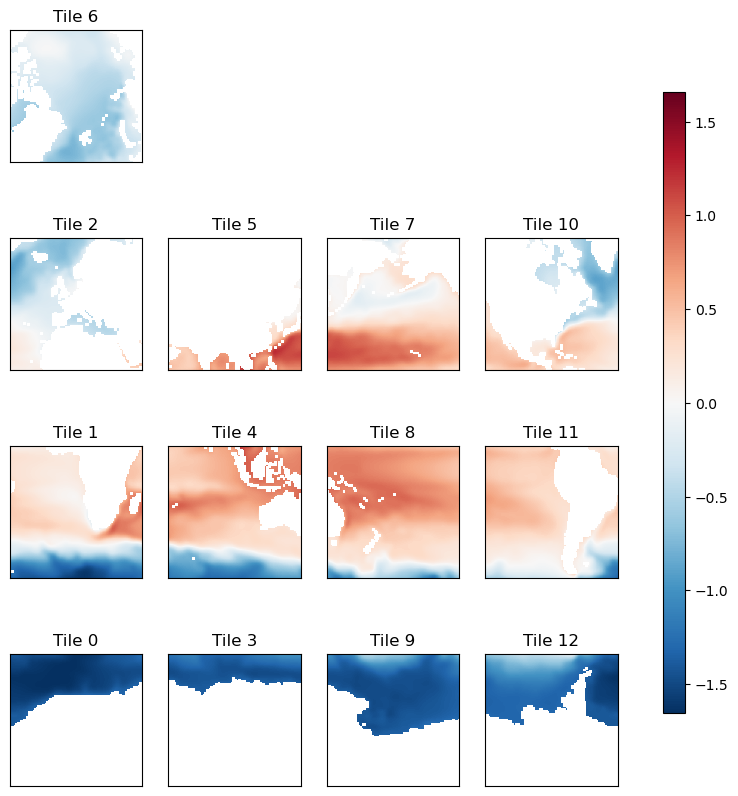

In [37]:
ecco.plot_tiles(ds_SSH_s3.SSH[0,:,:,:], layout='latlon',rotate_to_latlon=True,show_tile_labels=True, show_colorbar=True);

### Visualization via quick plot!

In [38]:
tile1 = 11
tile2 = 12
ssh_1 = ds_SSH_s3.SSH[:,tile1,:,:]
ssh_2 = ds_SSH_s3.SSH[:,tile2,:,:]

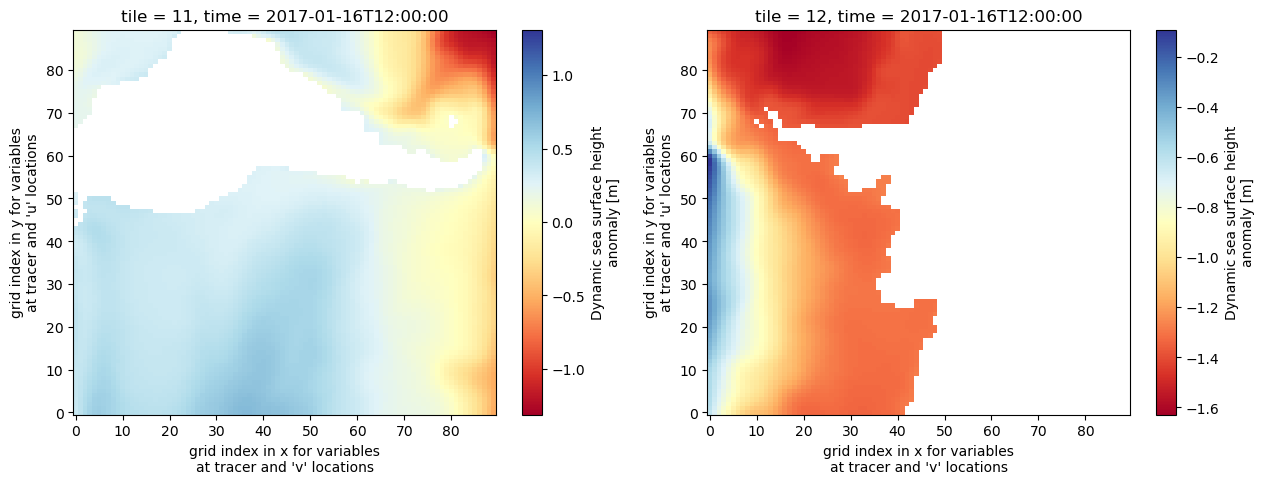

In [39]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ssh_1[0,:,:].plot(cmap="RdYlBu")
plt.subplot(1,2,2)
ssh_2[0,:,:].plot(cmap="RdYlBu")

### Selcetion of two locations to analyze the geostrophic transport through the Drake passage

For SSH mask [i,j]: Chile point --> [88,60] Antarctica point --> [6,70]

### Looking for the first point at the Antarctic side

In [40]:
# Geo point area selection
lon_xc = ds_SSH_s3.XC[tile1,:,:].values
lat_yc = ds_SSH_s3.YC[tile1,:,:].values
geotest = (lon_xc >= -70) & (lon_xc <= -69) & (lat_yc >= -57) & (lat_yc <= -56.5)
geoindex = np.argwhere(geotest)
geoindex

array([[58, 89]])

In [94]:
# # Get indexes
# xmin = min(geoindex[:,1]);xmax = max(geoindex[:,1])
# ymin = min(geoindex[:,0]);ymax = max(geoindex[:,0])
# iid = slice(xmin,xmax);jid = slice(ymin,ymax)
# # lon and lad true values in the area of interest
# Lon = lon_xc[jid,iid];Lat = lat_yc[jid,iid]

In [41]:
iid = geoindex.squeeze()[1];jid = geoindex.squeeze()[0]
# lon and lad true values in the area of interest
Lon = lon_xc[jid,iid];Lat = lat_yc[jid,iid]
Lon,Lat

(-69.5, -56.73891)

Text(0.5, 1.0, 'Zoom into around the green point on the Tile 11')

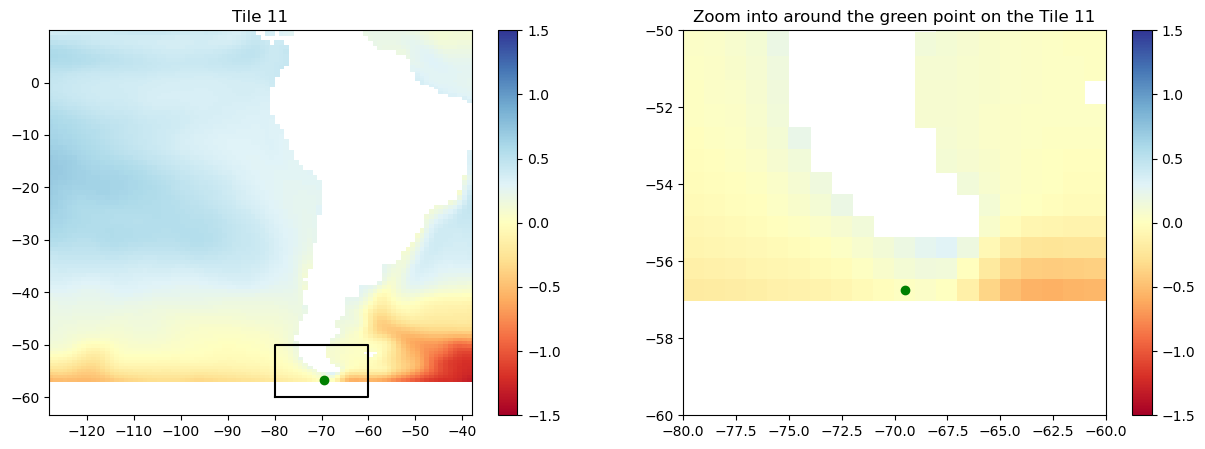

In [42]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
cb = plt.pcolor(lon_xc,lat_yc,ssh_1[0,:,:],cmap="RdYlBu",vmin=-1.5,vmax=1.5)
plt.colorbar(cb)
plt.plot([-80, -60, -60, -80, -80],[-60,-60,-50,-50,-60],'-k')
cac = plt.plot(lon_xc[jid,iid],lat_yc[jid,iid],'go')
plt.title("Tile 11")
plt.subplot(1,2,2)
cb = plt.pcolor(lon_xc,lat_yc,ssh_1[0,:,:],cmap="RdYlBu",vmin=-1.5,vmax=1.5)
plt.colorbar(cb)
cac = plt.plot(lon_xc[jid,iid],lat_yc[jid,iid],'go')
plt.xlim(-80,-60);plt.ylim(-60,-50)
plt.title("Zoom into around the green point on the Tile 11")

### Looking for the second point at the Antarctic side
Here, I will use the one identified by my colleague Marie Z.

In [43]:
lon_xc2 = ds_SSH_s3.XC[tile2,:,:].values
lat_yc2 = ds_SSH_s3.YC[tile2,:,:].values
geotest = (lon_xc2 >= -70) & (lon_xc2 <= -69) & (lat_yc2 >= -64) & (lat_yc2 <= -63.75)
geoindex = np.argwhere(geotest)
geoindex

array([[58, 14]])

In [49]:
iid2 = geoindex.squeeze()[1];jid2 = geoindex.squeeze()[0]
# lon and lad true values in the area of interest
Lon2 = lon_xc2[jid2,iid2];Lat2 = lat_yc2[jid2,iid2]
Lon2,Lat2

(-69.5, -63.992294)

Text(0.5, 1.0, 'Zoom into around the green point on the Tile 12')

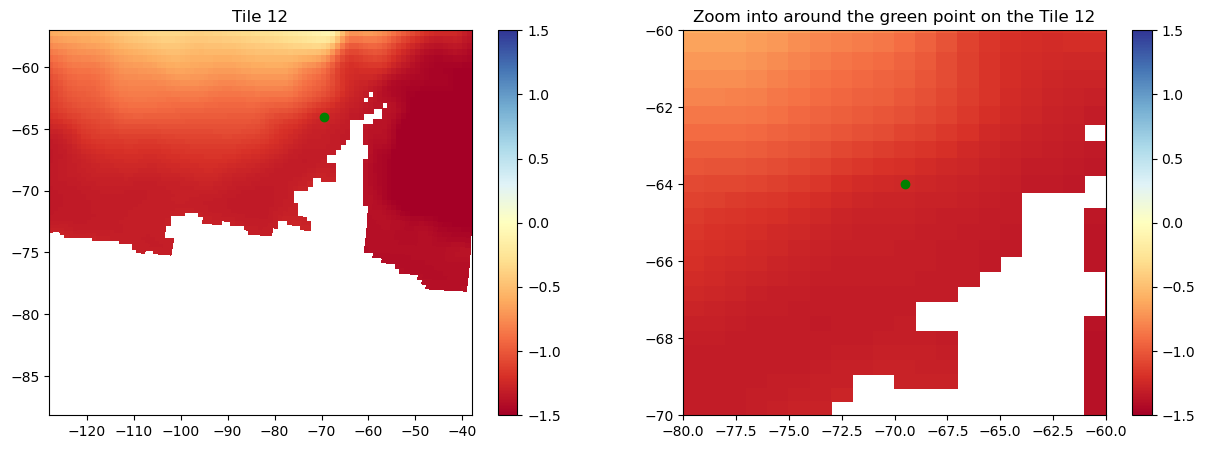

In [48]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
cb = plt.pcolor(lon_xc2,lat_yc2,ssh_2[0,:,:],cmap="RdYlBu",vmin=-1.5,vmax=1.5)
plt.colorbar(cb)
# plt.plot([-80, -60, -60, -80, -80],[-60,-60,-50,-50,-60],'-k')
cac = plt.plot(lon_xc2[jid2,iid2],lat_yc2[jid2,iid2],'go')
plt.title("Tile 12")
plt.subplot(1,2,2)
cb = plt.pcolor(lon_xc2,lat_yc2,ssh_2[0,:,:],cmap="RdYlBu",vmin=-1.5,vmax=1.5)
plt.colorbar(cb)
cac = plt.plot(lon_xc2[jid2,iid2],lat_yc2[jid2,iid2],'go')
plt.xlim(-80,-60);plt.ylim(-70,-60)
plt.title("Zoom into around the green point on the Tile 12")

### Now the two points are selected, let's make the mask for the adjoint tool

In [54]:
SSH_mask = ds_SSH_s3.SSH[0,:,:,:]*0

### Replacing the point at Chilli side by 1 and Antarctica side by -1

In [58]:
SSH_mask[tile1,jid,iid] = 1
SSH_mask[tile2,jid2,iid2] = -1

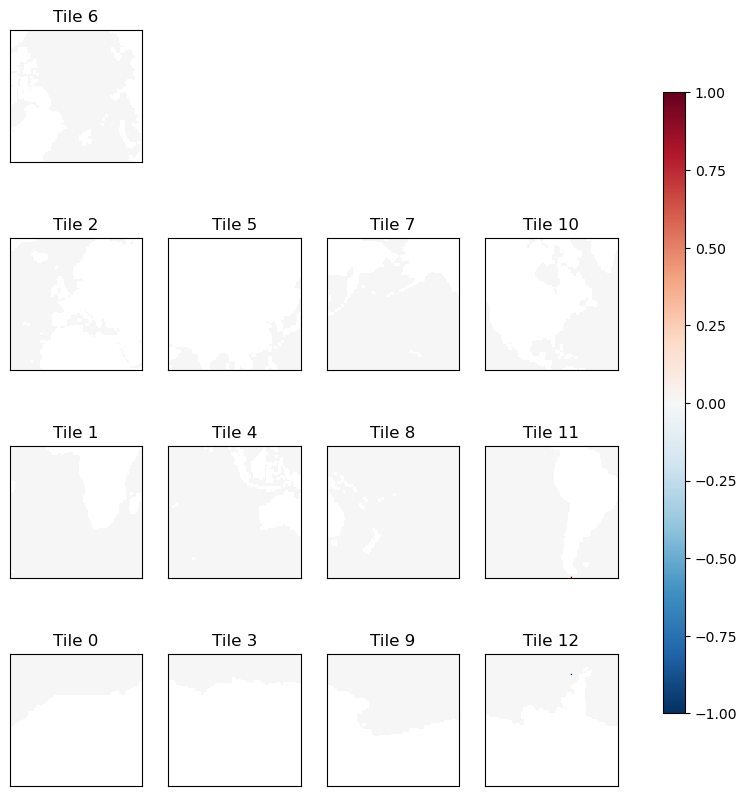

In [62]:
ecco.plot_tiles(SSH_mask, layout='latlon',rotate_to_latlon=True,show_tile_labels=True, show_colorbar=True);

### Saving the mask file into compact format

In [63]:
SSH_mask_compact = ecco.llc_tiles_to_compact(SSH_mask)

llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (90, 90)
llc_faces_to_compact: data_compact array shape (1170, 90)
llc_faces_to_compact: data_compact array dtype float32


### Converting the compacted format file into binary format

In [66]:
SSH_mask_compact.astype('>f4').tofile('/home/jovyan/efs_ecco/ohoundeg/'+'ssh_mask_compac_binary.bin')

In [65]:
os.system('pwd')

/home/jovyan/efs_ecco/ohoundeg/ojh_scripts/EH24-ESPRESSO/contributors/ohoundeg


0